# Workshop Final - NPL - Clasificación de Sentimientos

**Integrantes del grupo:**

- Kevin Tasat
- Martha Alvarez
- Fernando Roa

### Resumen



El dataset a evaluar tiene un total de 16000 textos a los cuales se les asocian diferentes sentimientos o emociones. El objetivo de este trabajo es mediante análisis de lenguaje natural preparar la información y posteriormente entrenar un modelo de clasificación de emociones.

## Exploración inicial de la data

### Importar librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns;sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import math
from math import sqrt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from IPython.display import Image
import itertools
import plotly.express as px
from itertools import chain
from pprint import pprint
from time import time
import logging

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from collections import defaultdict
#nltk.download('all')
#nltk.download('averaged_perceptron_tagger')

from collections import Counter
import re
import string

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS

from textblob import TextBlob

from wordhoard import Antonyms
import random

pd.set_option('display.float_format', lambda x: '%.5f' % x)


### Lectura del dataset

In [2]:
df = pd.read_csv('train.txt',delimiter=";",header=None,names=['corpus','feeling'])

In [3]:
# Visualizamos las primeras y las últimas filas del dataset

df

,corpus,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Tamaño del dataset

In [4]:
print(f'El dataset cuenta con {df.shape[0]} filas y {df.shape[1]} columnas')

El dataset cuenta con 16000 filas y 2 columnas


### Cantidad de valores nulos

In [5]:
df.isnull().sum()

corpus     0
feeling    0
dtype: int64

Como podemos observar, la data es muy completa, no existen valores nulos.

### Hipotesis Nula por clase - Proporción original de cada sentimiento en el dataset

In [6]:
# Calculamos la participación de cada sentimiento en el dataset

df.feeling.value_counts(normalize=True)

joy        0.33513
sadness    0.29163
anger      0.13494
fear       0.12106
love       0.08150
surprise   0.03575
Name: feeling, dtype: float64

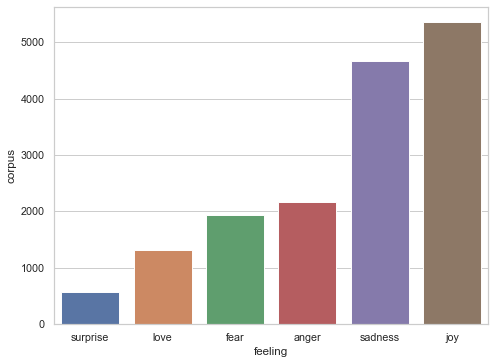

In [7]:
# Gráfico de barras con el conteo de las apariciones de cada sentimiento

result=df.groupby(by="feeling").count().sort_values(by=['corpus']).reset_index()
fig=figure(figsize=(8, 6), dpi=70)
sns.barplot(x='feeling', y="corpus", data=result, order=result['feeling'])
plt.show()

De acuerdo a lo anterior, existen dos sentimientos cuya participación combinada supera el 60% de la participación en la data, siendo estos "joy" y "sadness". En el otro extremo hay un sentimiento que tiene una participación de apenas el 3.5% el cual es "surprise".

# Se deben eliminar esta celdas?

### Instancio un modelo solo para probar "hipotesis nula"

Probar sobre Test para ver como da un modelo base sin intervencion del texto

## Limpieza de la data

In [8]:
# Se construye un diccionario con contracciones y sus respectivas palabras extendidas

contractions = { 
"ain't": "am not",
"aren't": "am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I had",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [9]:
# Se carga el diccionario de stopwords en inglés como base y se agregan las mismas palabras del mismo eliminando la comilla " ' "

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words=stopwords.words('english');

hifen =' '.join(stop_words)
hifen = re.sub("'", '', hifen)    
hifen=word_tokenize(hifen)

stop_words.extend(hifen)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# Se crea una función para limpiar el texto

def clean_text(text):
    '''Se remueven caracteres indeseados, stopwords y formatea el texto'''
    
    # Convertir el texto en minúscula
    text = text.lower()
    
    # Reemplaza contracciones por su formato extendido 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Formatea palabras y remueve caracteres no deseados
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Remueve stopwords
    text = text.split()
    stops = stop_words
    text = [w for w in text if not w in stops]
    text = " ".join(text)
        
    # Corrección de ortografía (tarda demasiado y no da buenos resultados)
    
    #text = TextBlob(text).correct() 
    #text = text.__str__() # opcion 1 (tarda demasiado)
    #text = '{}'.format(text) #opcion2 (tarda demasiado)
    #text = str(TextBlob(text).correct()) #opcion3 (tarda demasiado)
    
    # Lematizar 
    
    #Defaultdict is a container like dictionaries present in the module collections. 
    #Defaultdict is a sub-class of the dictionary class that returns a dictionary-like object. 
    #The functionality of both dictionaries and defaultdict are almost same except for the fact that defaultdict never raises a KeyError. 
    #It provides a default value for the key that does not exists.

    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    tokens = word_tokenize(text)
    lmtzr = WordNetLemmatizer()
    
    new_text2=[]
    
    for token, tag in pos_tag(tokens):
        lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
        new_text2.append(lemma)
        text=" ".join(new_text2)
        
    return text

In [11]:
# Se crea una función de limpieza lambda a partir de la función de limpieza original

clean_lambda = lambda x: clean_text(x)

In [12]:
# Se crea una nueva columna con el corpus limpio

df['clean_corpus'] = df.corpus.apply(clean_lambda)

# Visualizamos los primeros 5 registros

df.head()

,corpus,feeling,clean_corpus
0,i didnt feel humiliated,sadness,feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damn hopeful around someon...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalgic fireplace know still property
4,i am feeling grouchy,anger,feel grouchy


## Análisis profundo de la data después de limpieza

In [13]:
# Se listan las clases posibles presentes en el dataset

clases=list(df.feeling.unique())
clases=sorted(clases)
clases

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [14]:
# Buscamos las palabras más frecuentes por sentimiento

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': 'english',
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

most_common=[]

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['clean_corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    #terms=np.array(vectorizer.get_feature_names_out());
    # Dependiendo a la versión de TfidfVectorizer la línea anterior puede arrojar error, para ello usar la siguiente línea 
    terms=np.array(vectorizer.get_feature_names());
    most_common.append(terms[indices[:20]])

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  anger
['like' 'feeling' 'im' 'feel like' 'cold' 'want' 'know' 'angry'
 'irritable' 'im feel' 'really' 'wrong' 'time' 'greedy' 'fuck' 'cranky'
 'make' 'little' 'say' 'think']

 Clase  fear
['feeling' 'im' 'like' 'feel like' 'little' 'im feel' 'know' 'bit'
 'anxious' 'vulnerable' 'strange' 'insecure' 'uncertain' 'feel little'
 'nervous' 'feel vulnerable' 'afraid' 'make' 'terrify' 'apprehensive']

 Clase  joy
['like' 'im' 'feel like' 'feeling' 'make' 'im feel' 'really' 'time'
 'pretty' 'know' 'good' 'want' 'think' 'day' 'love' 'happy' 'need' 'life'
 'say' 'make feel']

 Clase  love
['like' 'love' 'feel like' 'im' 'feeling' 'feel love' 'sympathetic' 'hot'
 'fond' 'horny' 'passionate' 'want' 'care' 'feel sympathetic' 'delicate'
 'know' 'bless' 'accept' 'nostalgic' 'really']

 Clase  sadness
['like' 'feeling' 'im' 'feel like' 'know' 'really' 'make' 'time' 'im feel'
 'think' 'little' 'want' 'day' 'bit' 'ive' 'thing' 'bad' 'make feel'
 'life' 'say']

 Clase  surprise
['feeling' 'weird

In [15]:
# Obtenemos una única lista que encadena las listas de palabras más frecuentes por sentimiento

new_stop_words=list(chain(*most_common))

In [16]:
# Visualizamos las palabras más repetidas de la lista ya obtenida de palabras más frecuentes
# de todas las categorías de sentimiento

Counter(new_stop_words).most_common()

[('like', 6),
 ('feeling', 6),
 ('im', 6),
 ('feel like', 5),
 ('know', 5),
 ('want', 4),
 ('im feel', 4),
 ('really', 4),
 ('make', 4),
 ('little', 4),
 ('time', 3),
 ('say', 3),
 ('think', 3),
 ('bit', 3),
 ('strange', 2),
 ('day', 2),
 ('love', 2),
 ('life', 2),
 ('make feel', 2),
 ('cold', 1),
 ('angry', 1),
 ('irritable', 1),
 ('wrong', 1),
 ('greedy', 1),
 ('fuck', 1),
 ('cranky', 1),
 ('anxious', 1),
 ('vulnerable', 1),
 ('insecure', 1),
 ('uncertain', 1),
 ('feel little', 1),
 ('nervous', 1),
 ('feel vulnerable', 1),
 ('afraid', 1),
 ('terrify', 1),
 ('apprehensive', 1),
 ('pretty', 1),
 ('good', 1),
 ('happy', 1),
 ('need', 1),
 ('feel love', 1),
 ('sympathetic', 1),
 ('hot', 1),
 ('fond', 1),
 ('horny', 1),
 ('passionate', 1),
 ('care', 1),
 ('feel sympathetic', 1),
 ('delicate', 1),
 ('bless', 1),
 ('accept', 1),
 ('nostalgic', 1),
 ('ive', 1),
 ('thing', 1),
 ('bad', 1),
 ('weird', 1),
 ('funny', 1),
 ('curious', 1),
 ('feel funny', 1),
 ('overwhelm', 1),
 ('shock', 1),
 ('

In [17]:
# Si una palabra fue encontrada en dos o más sentimientos será añadida a las stopwords

add_stop_words = [word for word, count in Counter(new_stop_words).most_common() if count > 2]
add_stop_words

['like',
 'feeling',
 'im',
 'feel like',
 'know',
 'want',
 'im feel',
 'really',
 'make',
 'little',
 'time',
 'say',
 'think',
 'bit']

In [18]:
# Se agregan palabras adicionales a la lista de stopwords

stop_words.extend(add_stop_words)
stop_words.append('shall')
stop_words.append('im')
stop_words.append('feel')
stop_words.append('ive')
stop_words.append('still')
stop_words.append('one')
stop_words.append('get')
stop_words.append('would')
stop_words.append('today')
stop_words.append('pretty')
stop_words.append('right')
stop_words.append('much')
stop_words.append('even')
stop_words.append('life')
stop_words.append('people')
stop_words.append('time')
stop_words.append('going')
stop_words.append('bit')
stop_words.append('want')
stop_words.append('think')
stop_words.append('thinking')
stop_words.append('make')
stop_words.append('makes')
stop_words.append('things')
stop_words.append('something')
stop_words.append('could')
stop_words.append('day')
stop_words.append('saying')
stop_words.append('also')
stop_words.append('without')
stop_words.append('actually')
stop_words.append('say')
stop_words.append('always')
stop_words.append('feelings')   
stop_words.append('quite')   
stop_words.append('work')   
stop_words.append('way') 
stop_words.append('many') 
stop_words.append('around')
stop_words.append('back')


# Tratamiento de Stopwords para abrir notebooks

In [19]:
df_stop_words = pd.DataFrame({'stopwords':stop_words})
df_stop_words.to_csv('stopwords.csv')
df_stop_words.head()

,stopwords
0,i
1,me
2,my
3,myself
4,we


In [20]:
df_stop_words.stopwords.tolist()

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Despúes de utilizar el nuevo listado de stopwords revisamos las palabras más comunes según el sentimiento

In [21]:
#Segunda limpieza

clases=['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'];

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': stop_words, # CAMBIO POR LISTA PERSONALIZADA DEFINIDA EN PASO ANTERIOR
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

most_common3=[]

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    #terms=np.array(vectorizer.get_feature_names_out())
    # Dependiendo a la versión de TfidfVectorizer la línea anterior puede arrojar error, para ello usar la siguiente línea 
    terms=np.array(vectorizer.get_feature_names());
    most_common3.append(terms[indices[:20]]);

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  sadness
['alone' 'sorry' 'disheartened' 'listless' 'stressed' 'punished' 'bad'
 'gloomy' 'stupid' 'homesick' 'miserable' 'discouraged' 'low' 'devastated'
 'depressed' 'pathetic' 'unhappy' 'horrible' 'awkward' 'shitty']

 Clase  anger
['irritable' 'angry' 'cranky' 'cold' 'bothered' 'pissed' 'fucked'
 'annoyed' 'selfish' 'wronged' 'greedy' 'irritated' 'insulted' 'stressed'
 'dissatisfied' 'agitated' 'mad' 'bitter' 'rebellious' 'jealous']

 Clase  love
['delicate' 'hot' 'nostalgic' 'caring' 'horny' 'loving' 'naughty'
 'passionate' 'longing' 'sympathetic' 'liked' 'fond' 'loved' 'love'
 'accepted' 'supportive' 'blessed' 'beloved' 'sweet' 'supporting']

 Clase  surprise
['overwhelmed' 'funny' 'weird' 'amazed' 'strange' 'curious' 'impressed'
 'shocked' 'surprised' 'amazing' 'dazed' 'stunned' 'remember' 'started'
 'feels' 'find' 'ludicrous' 'confused' 'dazed confused' 'sure']

 Clase  fear
['insecure' 'anxious' 'weird' 'shaken' 'vulnerable' 'scared' 'terrified'
 'apprehensive' 'nervou

In [22]:
new_stop_words3=list(chain(*most_common3))

In [23]:
Counter(new_stop_words3).most_common()

[('stressed', 2),
 ('agitated', 2),
 ('love', 2),
 ('overwhelmed', 2),
 ('weird', 2),
 ('strange', 2),
 ('confused', 2),
 ('sure', 2),
 ('alone', 1),
 ('sorry', 1),
 ('disheartened', 1),
 ('listless', 1),
 ('punished', 1),
 ('bad', 1),
 ('gloomy', 1),
 ('stupid', 1),
 ('homesick', 1),
 ('miserable', 1),
 ('discouraged', 1),
 ('low', 1),
 ('devastated', 1),
 ('depressed', 1),
 ('pathetic', 1),
 ('unhappy', 1),
 ('horrible', 1),
 ('awkward', 1),
 ('shitty', 1),
 ('irritable', 1),
 ('angry', 1),
 ('cranky', 1),
 ('cold', 1),
 ('bothered', 1),
 ('pissed', 1),
 ('fucked', 1),
 ('annoyed', 1),
 ('selfish', 1),
 ('wronged', 1),
 ('greedy', 1),
 ('irritated', 1),
 ('insulted', 1),
 ('dissatisfied', 1),
 ('mad', 1),
 ('bitter', 1),
 ('rebellious', 1),
 ('jealous', 1),
 ('delicate', 1),
 ('hot', 1),
 ('nostalgic', 1),
 ('caring', 1),
 ('horny', 1),
 ('loving', 1),
 ('naughty', 1),
 ('passionate', 1),
 ('longing', 1),
 ('sympathetic', 1),
 ('liked', 1),
 ('fond', 1),
 ('loved', 1),
 ('accepted', 

### Estaría bueno armar un wordcloud pero no me anda - TRABAJARLO

### Vectorización del Dataframe Original

In [24]:
# Visualizamos los primeros 5 registros del dataframe

df.head()

,corpus,feeling,clean_corpus
0,i didnt feel humiliated,sadness,feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damn hopeful around someon...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalgic fireplace know still property
4,i am feeling grouchy,anger,feel grouchy


In [25]:
params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': stop_words,
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

TF = (Number of times term T appears in the particular row) / (number of terms in that row)

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

tf1['tfidf'] = tf1['tf'] * tf1['idf']

In [26]:
# Vectorizamos  el dataframe original

df_vect_matrix=vectorizer.fit_transform(df.clean_corpus)
df_vect_matrix.shape

(16000, 5000)

In [27]:
# Debido que al vectorizar el dataframe el resultado el una matriz, se recrea la estructura de un dataframe

#f_vect = pd.DataFrame(df_vect_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df_vect = pd.DataFrame(df_vect_matrix.toarray(), columns=vectorizer.get_feature_names())
df_vect.index = df.index
df_vect

,abandon,abc,abdomen,ability,abit,able,able find,able go,able help,able move,...,york,young,young woman,youth,youtube,zealand,zero,zombie,zone,zoom
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15996,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15997,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15998,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Dataset agrupado por Feeling

In [28]:
# Se construye un dataframe nuevo donde se unifican todos los textos por sentimiento

sadness=' '.join(df[df.feeling=='sadness']['clean_corpus'])

anger=' '.join(df[df.feeling=='anger']['clean_corpus'])

love=' '.join(df[df.feeling=='love']['clean_corpus'])

surprise=' '.join(df[df.feeling=='surprise']['clean_corpus'])

fear=' '.join(df[df.feeling=='fear']['clean_corpus'])

joy=' '.join(df[df.feeling=='joy']['clean_corpus'])

d={'sadness':sadness,'anger':anger,'love':love,'surprise':surprise,'fear':fear,'joy':joy}

df_grouped=pd.DataFrame(list(d.items()),columns=['feeling','corpus'])

df_grouped=df_grouped.set_index(['feeling'])

In [29]:
# Se visualizan los primeros registros del dataframe por sentimiento

df_grouped.head()

,corpus
feeling,
sadness,feel humiliate go feeling hopeless damn hopefu...
anger,im grab minute post feel greedy wrong feel gro...
love,ever feel nostalgic fireplace know still prope...
surprise,ive take milligrams time recommend amount ive ...
fear,feel confuse life teenager jade year old man f...


In [30]:
# Se vectoriza el dataset limpio y agrupado

params_cv={'max_features': 5000,'max_df':0.75,'ngram_range': (1, 2),'stop_words': stop_words,'strip_accents': 'unicode'}

cv = CountVectorizer(**params_cv)
data_cv = cv.fit_transform(df_grouped.corpus)
#data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df_grouped.index
data_dtm

,aa,abandonment,abc,abdomen,abide,abit,able come,able express,able find,able go,...,youthful,youtube,yuuki,zach,zealand,zero,zombie,zone,zoom,zumba
feeling,,,,,,,,,,,,,,,,,,,,,
sadness,1,1,1,2,0,2,2,0,1,2,...,0,0,0,0,1,1,3,0,3,0
anger,1,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,2,0,0,0
love,0,0,0,0,0,0,0,1,1,0,...,0,2,0,1,0,0,0,2,0,1
surprise,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
fear,1,0,1,1,0,1,0,0,3,0,...,0,0,1,0,0,0,0,1,0,0
joy,0,1,2,1,2,0,1,2,0,2,...,2,4,1,2,2,4,0,8,2,2


In [31]:
# Se transpone el dataframe

data=data_dtm.transpose()

In [32]:
# Se encuentra el número de palabras únicas que cada aparecen en cada sentimiento

# Identificar los non-zero items en la matriz, lo que significan, las palabras que aparecen al menos una vez
unique_list = []
for feeling in data.columns:
    uniques = data[feeling].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Crear un nuevo dataframe con el conteo de las palabras únicas por sentimiento
data_words = pd.DataFrame(list(zip(clases, unique_list)), columns=['feeling', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,feeling,unique_words
3,surprise,602
2,love,1407
4,fear,1799
1,anger,1983
0,sadness,3258
5,joy,3647


In [33]:
# Se construye un diccionario con la cantidad de elementos por sentimiento

texts_by_feeling=dict(df.feeling.value_counts()) 

# Encontrar el número total de palabras por sentimiento (normalizado por la cantidad de elementos)
total_list = []
for feeling in data.columns:
    totals = sum(data[feeling])
    total_list.append(totals)

# Se adicionan la columna total_words y unique_ratio
data_words['total_words'] = total_list
data_words['unique_ratio'] = data_words['unique_words'] / data_words['total_words']

# Ordenar el dataframe por la columna unique_ratio
data_wpm_sort = data_words.sort_values(by='unique_ratio')
data_wpm_sort

,feeling,unique_words,total_words,unique_ratio
5,joy,3647,12010,0.30366
0,sadness,3258,9874,0.32996
1,anger,1983,4442,0.44642
4,fear,1799,3754,0.47922
2,love,1407,2624,0.53620
3,surprise,602,918,0.65577


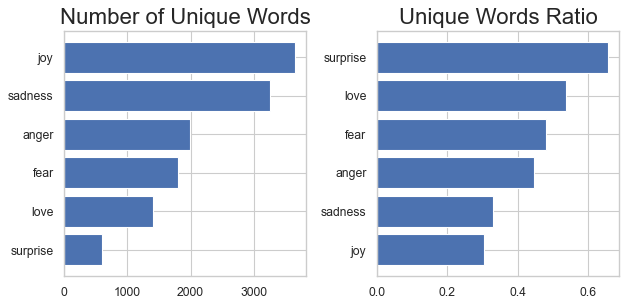

In [34]:
# Gráfico para mostrar los hallazgos

import numpy as np

figure(figsize=(8, 4), dpi=80)

y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.feeling)
plt.title('Number of Unique Words', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(y_pos, data_wpm_sort.unique_ratio, align='center')
plt.yticks(y_pos, data_wpm_sort.feeling)
plt.title('Unique Words Ratio', fontsize=20)

plt.tight_layout()
plt.show()

**Conclusión:** Es interesante ver la inversión del orden de sentimientos entre cantidad total de palabras únicas y el ratio de palabras únicas.
Observamos dos grupos bien diferenciados entre sadness y joy (grupo 1) vs el resto de los sentimientos (grupo 2), donde vemos que el primer grupo si bien posee la mayor cantidad de palabras únicas, estas mismas palabras se usan con gran frecuencia al expresarse (lo que hace que el valor de unique word ratio disminuya) mientras que el segundo posee un vocabulario más rico.

### Análisis de Polaridad y Subjetividad

In [35]:
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob

# Funciones lambda para polaridad y subjetividad
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

# Se calcula la polaridad y subjetividad para cada sentimienbto
df_grouped['polarity'] = df_grouped['corpus'].apply(pol)
df_grouped['subjectivity'] = df_grouped['corpus'].apply(sub)
df_grouped

,corpus,polarity,subjectivity
feeling,,,
sadness,feel humiliate go feeling hopeless damn hopefu...,-0.10193,0.58040
anger,im grab minute post feel greedy wrong feel gro...,-0.08493,0.58227
love,ever feel nostalgic fireplace know still prope...,0.17075,0.60415
surprise,ive take milligrams time recommend amount ive ...,0.08743,0.60299
fear,feel confuse life teenager jade year old man f...,-0.06357,0.55892
joy,petronas year feel petronas perform well make ...,0.25011,0.60553


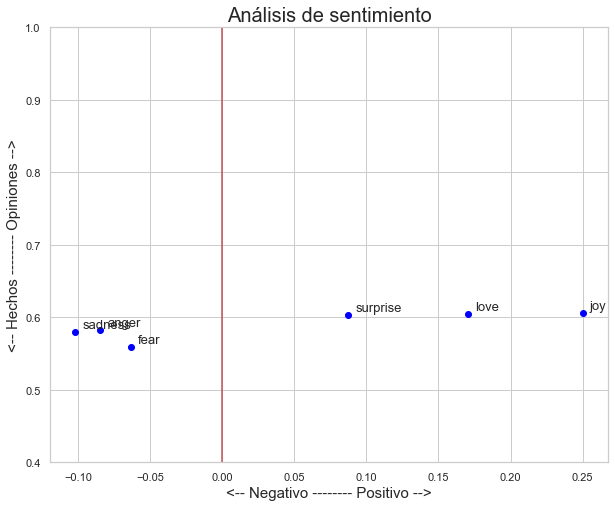

In [36]:
# Se grafican los resultados obtenidos

plt.rcParams['figure.figsize'] = [10, 8]

for index, feeling in enumerate(df_grouped.index):
    x = df_grouped.polarity.loc[feeling]
    y = df_grouped.subjectivity.loc[feeling]
    plt.scatter(x, y, color='blue')
    plt.text(x+.005, y+.005, df_grouped.index[index], fontsize=13)
    plt.ylim(0.4,1) 
    
plt.title('Análisis de sentimiento', fontsize=20)
plt.xlabel('<-- Negativo -------- Positivo -->', fontsize=15)
plt.ylabel('<-- Hechos -------- Opiniones -->', fontsize=15)
x1, y1 = [0, 0], [0, 1]
plt.plot(x1, y1, c='r')

plt.show()

Conclusión: Podemos ver que la distribución de los sentimientos de acuerdo a la polaridad es razonable de acuerdo a la realidad.
Una observación muy interesante es la cercanía del enojo con la tristeza. Acaso no todo enojo esconde tristeza? 

## Entrenamiento de modelos

### Modelo Random Forest con Polarity y Subjetivity

A modo de prueba se entrena un modelo únicamente con polarity y subjetivity de TextBlob

In [37]:
# Se crea una copia del dataset de entrenamiento

df_pol=df.copy()

In [38]:
# Se calculan las columnas de polaridad y subjetividad

df_pol['polarity'] = df_pol['corpus'].apply(pol)
df_pol['subjectivity'] = df_pol['corpus'].apply(sub)
df_pol

,corpus,feeling,clean_corpus,polarity,subjectivity
0,i didnt feel humiliated,sadness,feel humiliate,0.00000,0.00000
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damn hopeful around someon...,0.00000,0.00000
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minute post feel greedy wrong,-0.50000,0.90000
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalgic fireplace know still property,-0.50000,1.00000
4,i am feeling grouchy,anger,feel grouchy,0.00000,0.00000
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,brief time beanbag say anna feel like beaten,0.00000,0.43333
15996,i am now turning and i feel pathetic that i am...,sadness,turn feel pathetic still wait table sub teach ...,-1.00000,1.00000
15997,i feel strong and good overall,joy,feel strong good overall,0.37778,0.44444
15998,i feel like this was such a rude comment and i...,anger,feel like rude comment im glad,0.06667,0.70000


In [39]:
# Se establecen los parámetros de un random forest, con un peso de clases balanceadas
# como estrategia para contrarrestar el desbalanceo de las clases presentes en el dataframe

params={'max_depth': 10,'class_weight': "balanced"}
clf = RandomForestClassifier(**params)

In [40]:
# Se seleccionan las variables predictoras y la variable objetivo

X=df_pol[['polarity','subjectivity']]
y=df_pol.feeling

In [41]:
# Se entrena el random forest utilizando la data de entrenamiento

clf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [45]:
# Se importa un dataset el cual será usado para pruebas

df_test=pd.read_csv('test.txt',delimiter=";",header=None,names=['corpus','feeling'])

In [46]:
# Se crea una copia de la data de prueba

df_test_rf_pol=df_test.copy()

In [47]:
# Se calculan las columnas de polaridad y subjetividad

df_test_rf_pol['polarity'] = df_test_rf_pol['corpus'].apply(pol)
df_test_rf_pol['subjectivity'] = df_test_rf_pol['corpus'].apply(sub)

In [48]:
# Se seleccionan las variables predictoras y la variable objetivo sobre la data de prueba

X_test_rf_pol=df_test_rf_pol[['polarity','subjectivity']]
y_test_rf_pol=df_test_rf_pol.feeling

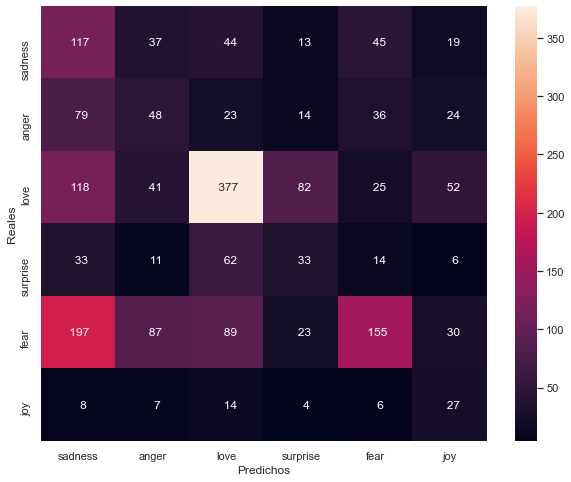

              precision    recall  f1-score   support

       anger     0.2120    0.4255    0.2830       275
        fear     0.2078    0.2143    0.2110       224
         joy     0.6190    0.5424    0.5782       695
        love     0.1953    0.2075    0.2012       159
     sadness     0.5516    0.2668    0.3596       581
    surprise     0.1709    0.4091    0.2411        66

    accuracy                         0.3785      2000
   macro avg     0.3261    0.3443    0.3123      2000
weighted avg     0.4489    0.3785    0.3919      2000



In [49]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=clf.predict(X_test_rf_pol)
sns.heatmap(confusion_matrix(y_test_rf_pol, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_rf_pol, predicciones, digits=4))

**Conclusión:** Como se observa, los resultados obtenidos no fueron buenos, por lo cual se descarta un modelo de predicción de sentimientos utilizando solamente las columnas de polaridad y subjetividad.